# Análisis del Índice BTC MtR en Pesos Argentinos

En el siguiente código, estamos accediendo a datos financieros utilizando la API de Índices MtR. Esta API proporciona información detallada sobre varios instrumentos financieros, incluido el Índice BTC MtR, que refleja el precio del Bitcoin en Pesos Argentinos (BTC/ARS). Estos datos son esenciales para el seguimiento y análisis de los mercados financieros en tiempo real.

Además, la API Índices MtR es de libre acceso y no requiere registro ni credenciales de acceso. Está disponible las 24 horas del día, los 365 días del año, lo que facilita su integración en aplicaciones y sistemas. Los datos se pueden consultar tanto de forma síncrona a través de solicitudes REST como de forma asíncrona mediante Web Socket para recibir actualizaciones automáticas cuando cambian.

In [1]:
import requests
import pandas as pd
import boto3
import os
from kaggle_secrets import UserSecretsClient

# Obtener las credenciales de AWS desde los secretos de usuario
user_secrets = UserSecretsClient()
access_key = user_secrets.get_secret("AWSAccessKeyId")
secret_key = user_secrets.get_secret("AWSSecretKey")
bucket_name = 'matbarofex-data'  # Nuevo nombre del bucket

# Crear el cliente de S3
s3_client = boto3.client('s3', aws_access_key_id=access_key, aws_secret_access_key=secret_key)

# Verificar si el bucket ya existe
response = s3_client.list_buckets()
existing_buckets = [bucket['Name'] for bucket in response['Buckets']]

if bucket_name not in existing_buckets:
    # El bucket no existe, se puede crear
    s3_client.create_bucket(Bucket=bucket_name)

# Lista de tokens
tokens = ['I.BTC', 'I.SOJA', 'I.MAIZ', 'I.TRIGO', 'I.AGTKSOYA', 'I.AGTKCORA', 'I.AGTKWHEA', 'I.CCL', 'I.RFX20', 'I.DOLAREXPO']

# Iterar sobre cada token
for token in tokens:
    # URL de la API de Matbarofex para el token actual
    url_token = f"https://api.matbarofex.com.ar/v1/rest/indices/{token}"

    # Realizar la solicitud GET a la API de Matbarofex para el token actual
    response_token = requests.get(url_token)
    
    try:
        response_token.raise_for_status()
        data_token = response_token.json()
        
        # Crear un DataFrame con los datos del token actual
        df_token = pd.DataFrame([data_token])

        # Nombre del archivo para el token actual con prefijo
        filename_token = f'{token}_matbarofex_{pd.Timestamp.now().strftime("%Y-%m-%d")}.csv'

        # Guardar el DataFrame del token actual en un archivo CSV
        df_token.to_csv(filename_token, index=False)

        # Subir el archivo CSV del token actual a S3
        s3_client.upload_file(filename_token, bucket_name, filename_token)
        
        # Borrar el archivo local después de subirlo a S3
        os.remove(filename_token)
    except requests.exceptions.RequestException as e:
        print(f"Error al realizar la solicitud para el token {token}: {e}")


Error al realizar la solicitud para el token I.DOLAREXPO: Expecting value: line 1 column 1 (char 0)


In [2]:
# Listar objetos en el bucket
objects = s3_client.list_objects(Bucket=bucket_name)

In [3]:
import boto3
import pandas as pd
from io import BytesIO

# Crear una lista para almacenar DataFrames
dataframes = []

# Iterar sobre los objetos y leer los archivos CSV desde S3
for obj in objects.get('Contents', []):
    filename = obj['Key']
    if (filename.startswith('matba') or filename.startswith('I.BTC_')) and filename.endswith('.csv'):
        # Leer el archivo CSV directamente desde S3
        obj_data = s3_client.get_object(Bucket=bucket_name, Key=filename)
        df = pd.read_csv(BytesIO(obj_data['Body'].read()))

        # Agregar el DataFrame a la lista
        dataframes.append(df)

In [4]:
import pandas as pd

# Supongamos que dataframes es la lista que contiene tus DataFrames

# Concatenar todos los DataFrames en un solo DataFrame
df_combinado = pd.concat(dataframes, ignore_index=True)

In [5]:
df_combinado

,closeIndexDate,closeIndexValue,costOfTrade,indexValue,mdEntryDateTime,nominalValue,representativeness,symbol,unixTimestamp
0,2024-02-07 20:00:00,53937166.42,880877.68,54966271.08,2024-02-08 18:01:00,2.59,R,I.BTC,1.707415e+09
1,NaN,NaN,464296.05,27395924.95,2023-10-17 20:57:00,5.15,R,I.BTC,1.697576e+09
2,NaN,NaN,419446.95,27367063.23,2023-10-18 20:49:00,4.00,R,I.BTC,1.697662e+09
3,NaN,NaN,543069.64,29076373.11,2023-10-19 20:58:00,4.00,R,I.BTC,1.697749e+09
4,NaN,NaN,1504967.02,35126539.26,2023-10-20 20:43:00,3.36,R,I.BTC,1.697835e+09
...,...,...,...,...,...,...,...,...,...
107,2024-02-03 20:00:00,53274899.10,1058614.06,52927000.29,2024-02-04 17:34:00,3.67,R,I.BTC,1.707068e+09
108,2024-02-04 20:00:00,52499477.87,1161572.27,53160342.68,2024-02-05 18:11:00,3.52,R,I.BTC,1.707157e+09
109,2024-02-05 20:00:00,53100182.88,1051914.84,52954797.43,2024-02-06 17:54:00,3.69,R,I.BTC,1.707242e+09
110,2024-02-06 20:00:00,52553214.20,1170693.92,54094599.91,2024-02-07 17:39:00,3.71,R,I.BTC,1.707328e+09


In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppose df_combinado has the necessary columns, including "mdEntryDateTime," "indexValue," and "nominalValue."

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("indexValue", "nominalValue"))

# Subplot 1: indexValue on the left
# Subplot 1: indexValue on the left
fig.add_trace(go.Scatter(x=df_combinado['mdEntryDateTime'], y=df_combinado['indexValue'], name='indexValue', line=dict(color='#1C598A')), row=1, col=1)
fig.update_yaxes(title_text="ARS", row=1, col=1)


# Subplot 2: nominalValue on the right in bar format
fig.add_trace(go.Bar(x=df_combinado['mdEntryDateTime'], y=df_combinado['nominalValue'], name='nominalValue', marker=dict(color='#6CADE1')), row=1, col=2)
fig.update_yaxes(title_text="Index", row=1, col=2)

# Customize the X-axis format
fig.update_xaxes(tickformat="%d %b %Y", row=1, col=1)
fig.update_xaxes(tickformat="%d %b %Y", row=1, col=2)

# Customize the title
fig.update_layout(
    title_text="<b style='color:#AA322F'>GBTC/ARS Index Analysis: indexValue and nominalValue</b>"
)

# Show the plot with subplots
fig.show()

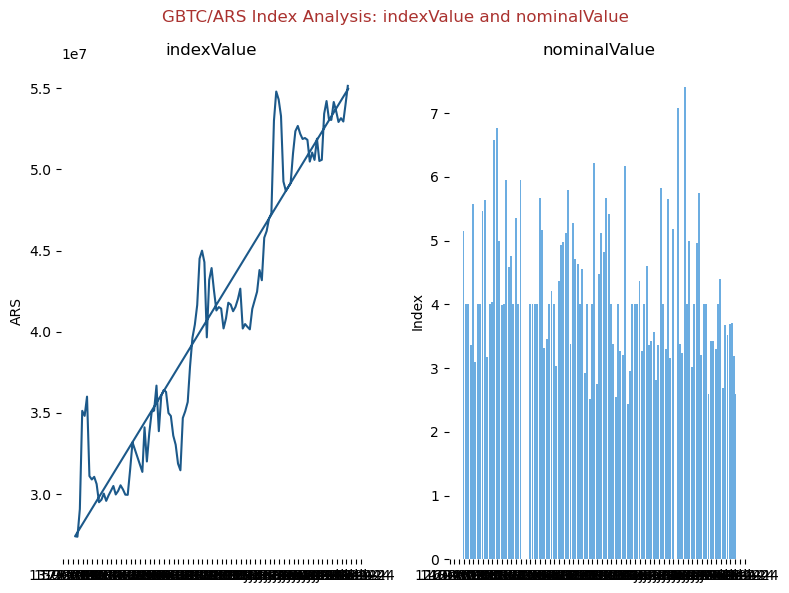

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Supongamos que 'df_combinado' es un DataFrame de pandas con las columnas 'mdEntryDateTime', 'indexValue' y 'nominalValue'

# Convertir 'mdEntryDateTime' a objetos de fecha y hora
df_combinado['mdEntryDateTime'] = pd.to_datetime(df_combinado['mdEntryDateTime'])

# Crear una figura con dos subplots y ajustar el tamaño a 8x6 pulgadas
fig_matba_static = plt.figure(figsize=(8, 6))

# Subplot 1: indexValue en la izquierda sin recuadro
plt.subplot(121, frameon=False)
plt.plot(df_combinado['mdEntryDateTime'], df_combinado['indexValue'], label='indexValue', color='#1C598A')
plt.title('indexValue')
plt.ylabel('ARS')

# Cambiar el formato del eje x a "20-oct-23" y rotar las etiquetas
date_format = mdates.DateFormatter('%d-%b-%y')
plt.gca().xaxis.set_major_formatter(date_format)

# Configurar la separación de las etiquetas en el eje x (cada dos días)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

plt.xticks(rotation=0)  # Mantener las etiquetas horizontales

# Subplot 2: nominalValue en formato de barras en la derecha sin recuadro
plt.subplot(122, frameon=False)
plt.bar(df_combinado['mdEntryDateTime'], df_combinado['nominalValue'], label='nominalValue', color='#6CADE1')
plt.title('nominalValue')
plt.ylabel('Index')

# Aplicar el mismo formato y separación de fechas al segundo subplot
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

plt.xticks(rotation=0)

# Añadir título general
plt.suptitle('GBTC/ARS Index Analysis: indexValue and nominalValue', color='#AA322F')

plt.tight_layout()  # Ajustar los subplots para evitar superposiciones

# Guarda el gráfico como un archivo PDF
plt.savefig("matba-rofex.pdf", format="pdf")
plt.show()


In [8]:
pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import chart_studio

In [10]:
import chart_studio.plotly as py

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_3 = user_secrets.get_secret("CHARTSTUDIO_BCRA_API_KEY")

In [12]:
# Graf de Vol 
chart_studio.tools.set_credentials_file(username='crypto-financial-stability-monitor', 
                                        api_key=secret_value_3)
py.plot(fig, filename = 'matba-rofex', auto_open=True)

'https://plotly.com/~crypto-financial-stability-monitor/1152/'